In [1]:
import pandas as pd,numpy as np

In [2]:
tmp1 = pd.read_csv('CB_Nov16_Enrich_02Websites_final_data_dec28.csv')
tmp2 = pd.read_csv('SAAS_Classified_final_data_dec28.csv')
df = pd.concat([tmp1,tmp2],ignore_index=True)

In [16]:
df.shape

(885, 7)

In [7]:
df.ix[df['website_text']=='404 - Object Not Found','website_text'] = ''

In [10]:
df.head()

,website,demo_present,login_present,pricing_present,score,website_text,saas_subscription
0,http://www.ultracartstore.com,False,False,False,0.0,,False
1,http://www.borathyun.wordpress.com,True,True,True,41.0,Bienvenue – toujours de l'avant et plus déterm...,False
2,http://www.globalmillennials.org,False,False,False,0.0,Global Millennials For Progress Home About Us ...,False
3,http://www.les-artisans-francais.fr,False,False,False,0.0,"Artisans-francais, l'annuaire des professionne...",False
4,http://www.nedboxgroup.com,False,False,False,0.0,Nedboxgroup Ltd. Группа компаний Nedboxgroup L...,False


In [19]:
df = df.drop_duplicates('website')
df.shape

(885, 7)

In [2]:
#text processing
import nltk,re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from text_processing import extract_phrases
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import nltk,re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from text_processing import extract_phrases

In [25]:
grammar = r"""
  NP1: {<JJ><NN.*>+}          # Chunk sequences of JJ, NN
  NP2: {<NN.*>+<JJ>}          # Chunk sequences of NN and JJ
  NP3: {<NN.*>+}                  #Noun phrases
  VP: {<VB.*><NN.*>+} # Chunk verbs and their arguments
  """
phr_list = ['NP1','NP2','NP3','VP']
tag_list = ['NN','NNS','NNP','NNPS','VB','VBD','VBG','VBN','VBP','VBZ']
stop_words = stopwords.words()+['http','https','goo','isnt','wwwfacebookcomtr','wwwgoogletagmanagercomnshtml',
                               'and','be','do','facebook','for','in','is','inc','linkedin','of','the','to']
cp = nltk.RegexpParser(grammar)
pe = extract_phrases.PhraseExtractor()
snowball_stemmer = SnowballStemmer('english')
wordnet_lemmatizer = WordNetLemmatizer()
reg_exp = re.compile('[^a-zA-Z ]',re.IGNORECASE)
def tokenizer(text,stem_type='lemmatize'):
    pos_tags = nltk.pos_tag(nltk.word_tokenize(text))
    phrs = pe.extract_phrase_treeinput(cp.parse(pos_tags),['NP1','NP2','VP'])
    if stem_type == 'stem':
        wrds = [snowball_stemmer.stem(i[0]) for i in pos_tags if i[1] in tag_list]
    elif stem_type == 'lemmatize':
        wrds = [wordnet_lemmatizer.lemmatize(i[0]) for i in pos_tags if i[1] in tag_list]
    wrds = [wrd for wrd in wrds if wrd.lower() not in stop_words]
    if stem_type == 'stem':
        phrs = ['_'.join([snowball_stemmer.stem(wrd) for wrd in nltk.word_tokenize(phr)]) for phr in phrs]
    elif stem_type == 'lemmatize':
        phrs = ['_'.join([wordnet_lemmatizer.lemmatize(wrd) for wrd in nltk.word_tokenize(phr)]) for phr in phrs]
    else:
        phrs = ['_'.join([wrd for wrd in nltk.word_tokenize(phr)]) for phr in phrs]
    wrds = [reg_exp.sub('',i) for i in wrds]
    return wrds+phrs

In [27]:
df['website_text_phrases'] = df['website_text'].fillna('').\
    apply(lambda x: ' '.join(tokenizer(unicode(x,'ascii','ignore'))))

In [29]:
df.to_csv('final_data_used_dec28.csv',index=False,quoting=1,encoding='utf-8')

In [3]:
df = pd.read_csv('final_data_used_dec28.csv')

In [4]:
stop_words = stopwords.words()+['http','https','goo','isnt','wwwfacebookcomtr','wwwgoogletagmanagercomnshtml',
                               'and','be','do','facebook','for','in','is','inc','linkedin','of','the','to',
                               'using','use','home','get','us']
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.1,stop_words=stop_words)
tfidf = tfidf_vectorizer.fit_transform(df['website_text'].fillna(''))
tfidf.shape

(885, 692)

In [70]:
from scipy.sparse import hstack
from scipy.sparse.csr import csr_matrix
tfidf_n_vars = hstack([tfidf,
        csr_matrix(df[['demo_present','login_present','pricing_present']].values.astype(float))])
tfidf_n_vars.shape
# tfidf_n_vars = tfidf

(885, 695)

In [57]:
#new variables
reg_text = r'(([0-9]|$|\b)per|/)(\b| |\n|\r){0,2}(month|year|\bmo)\b'
df['per_month_present'] = df['website_text'].fillna('').str.contains(reg_text,case=False)
tfidf_n_vars = hstack([tfidf,
        csr_matrix(df[['demo_present','login_present','pricing_present','per_month_present']].values.astype(float))])
tfidf_n_vars.shape

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  app.launch_new_instance()


(885, 696)

In [59]:
df.groupby(['per_month_present','saas_subscription']).size()

per_month_present  saas_subscription
False              False                435
                   True                 306
True               False                 47
                   True                  97
dtype: int64

In [60]:
df[(df['per_month_present'] == True)&(df['saas_subscription'] == False)].head()

,website,demo_present,login_present,pricing_present,score,website_text,saas_subscription,website_text_phrases,naive_bayes_predictions,random_forest_prediction,linear_svm_prediction,per_month_present
1,http://www.borathyun.wordpress.com,True,True,True,41.0,Bienvenue – toujours de l'avant et plus déterm...,False,Bienvenue toujours jamais Skip content Bienven...,3.683605e-28,0.44,0.203320,True
5,http://www.pagey.io,False,True,True,8.4,Pagey Features Pricing Our Story Login Promote...,False,Pagey Features Pricing Story Login Promote ser...,3.745751e-02,0.51,0.480254,True
6,http://www.ninjatoolsuite.net,True,True,True,12.4,Ninja Tool Suite - HOME HOME View Pages DEMO S...,False,Ninja Tool Suite HOME HOME View Pages DEMO SIG...,1.000000e+00,0.56,0.680157,True
7,http://www.graphicbees.com,False,True,True,11.8,Graphic Bees – Unlimited Graphic Design Guaran...,False,Graphic Bees Unlimited Graphic Design Guarante...,4.197286e-15,0.39,0.202910,True
15,http://www.eveassist.com,False,False,True,21.6,"EveAssist <div style=""display:inline;""> <img h...",False,EveAssist div style display inline img heig...,1.000000e+00,0.51,0.618383,True


In [44]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.model_selection import cross_val_predict
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel,RFE

In [61]:
clf = make_pipeline(StandardScaler(with_mean=False),MultinomialNB()) 
clf.fit(tfidf_n_vars,df['saas_subscription'])
print 'traing predictions'
print classification_report(df['saas_subscription'],clf.predict(tfidf_n_vars))
print 'cross-validation predictions'
print classification_report(df['saas_subscription'],cross_val_predict(clf,
                                                     tfidf_n_vars,df['saas_subscription'],cv=10))

traing predictions
             precision    recall  f1-score   support

      False       0.85      0.78      0.81       482
       True       0.76      0.83      0.80       403

avg / total       0.81      0.81      0.81       885

cross-validation predictions
             precision    recall  f1-score   support

      False       0.78      0.71      0.74       482
       True       0.68      0.76      0.72       403

avg / total       0.74      0.73      0.73       885



In [350]:
hidden_layer_sizes=(10,)
alpha = 1
clf = make_pipeline(StandardScaler(with_mean=False),MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,alpha=alpha)) 
clf.fit(tfidf_n_vars,df['saas_subscription'])
print 'traing predictions'
print classification_report(df['saas_subscription'],clf.predict(tfidf_n_vars))
print 'cross-validation predictions'
print classification_report(df['saas_subscription'],cross_val_predict(clf,
                                                     tfidf_n_vars,df['saas_subscription'],cv=10))

traing predictions
             precision    recall  f1-score   support

      False       0.98      0.99      0.99       482
       True       0.99      0.98      0.98       403

avg / total       0.98      0.98      0.98       885

cross-validation predictions
             precision    recall  f1-score   support

      False       0.70      0.72      0.71       482
       True       0.65      0.63      0.64       403

avg / total       0.68      0.68      0.68       885



In [46]:
C = 0.00005
clf = make_pipeline(StandardScaler(with_mean=False),LinearSVC(C=C)) 
clf.fit(tfidf_n_vars,df['saas_subscription'])
print 'traing predictions'
print classification_report(df['saas_subscription'],clf.predict(tfidf_n_vars))
print 'cross-validation predictions'
print classification_report(df['saas_subscription'],cross_val_predict(clf,
                                                     tfidf_n_vars,df['saas_subscription'],cv=10))

traing predictions
             precision    recall  f1-score   support

      False       0.87      0.82      0.84       482
       True       0.79      0.86      0.82       403

avg / total       0.84      0.83      0.83       885

cross-validation predictions
             precision    recall  f1-score   support

      False       0.79      0.71      0.74       482
       True       0.69      0.77      0.73       403

avg / total       0.74      0.74      0.74       885



In [71]:
C = 0.001
clf = make_pipeline(StandardScaler(with_mean=False),SVC(C=C,kernel='linear')) 
clf.fit(tfidf_n_vars,df['saas_subscription'])
print 'traing predictions'
print classification_report(df['saas_subscription'],clf.predict(tfidf_n_vars))
print 'cross-validation predictions'
print classification_report(df['saas_subscription'],cross_val_predict(clf,
                                                     tfidf_n_vars,df['saas_subscription'],cv=10))

traing predictions
             precision    recall  f1-score   support

      False       0.86      0.89      0.87       482
       True       0.86      0.83      0.84       403

avg / total       0.86      0.86      0.86       885

cross-validation predictions
             precision    recall  f1-score   support

      False       0.77      0.77      0.77       482
       True       0.72      0.72      0.72       403

avg / total       0.75      0.75      0.75       885



In [10]:
n_estimators = 100
min_samples_split=2
min_samples_leaf=1
max_depth = None
clf = make_pipeline(StandardScaler(with_mean=False),RandomForestClassifier(
    n_estimators=n_estimators,min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,max_depth=max_depth)) 
clf.fit(tfidf_n_vars,df['saas_subscription'])
print 'traing predictions'
print classification_report(df['saas_subscription'],clf.predict(tfidf_n_vars))
print 'cross-validation predictions'
print classification_report(df['saas_subscription'],cross_val_predict(clf,
                                                     tfidf_n_vars,df['saas_subscription'],cv=10))

traing predictions
             precision    recall  f1-score   support

      False       0.98      1.00      0.99       482
       True       0.99      0.98      0.99       403

avg / total       0.99      0.99      0.99       885

cross-validation predictions
             precision    recall  f1-score   support

      False       0.76      0.78      0.77       482
       True       0.72      0.70      0.71       403

avg / total       0.74      0.74      0.74       885



identifying important features

In [48]:
vocab_list = [0]*len(tfidf_vectorizer.vocabulary_)
for wrd in tfidf_vectorizer.vocabulary_:
    vocab_list[tfidf_vectorizer.vocabulary_[wrd]] = wrd
vocab_list.extend(['demo_present','login_present','pricing_present','per_month_present'])

In [50]:
n_estimators = 100
min_samples_split=2
min_samples_leaf=1
max_depth = None
clf = RandomForestClassifier(
    n_estimators=n_estimators,min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,max_depth=max_depth)
clf.fit(tfidf_n_vars,df['saas_subscription'])
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), vocab_list), 
             reverse=True)

Features sorted by their score:
[(0.0167, u'demo'), (0.0149, u'platform'), (0.0127, u'data'), (0.0123, 'demo_present'), (0.0097, u'blog'), (0.0083, u'careers'), (0.008, u'time'), (0.0078, u'request'), (0.0077, u'learn'), (0.007, u'mobile'), (0.0066, u'privacy'), (0.0064, u'works'), (0.0064, u'software'), (0.0063, u'features'), (0.0062, u'terms'), (0.0057, u'solution'), (0.0057, u'resources'), (0.0057, u'automatically'), (0.0056, u'enjoy'), (0.0055, u'app'), (0.0053, u'integrations'), (0.0053, u'company'), (0.0053, u'across'), (0.0052, u'management'), (0.005, u'found'), (0.0049, u'used'), (0.0049, u'tools'), (0.0049, u'integration'), (0.0045, u'technology'), (0.0045, u'contact'), (0.0043, u'performance'), (0.0043, u'analytics'), (0.0042, u'manager'), (0.004, u'team'), (0.0039, u'users'), (0.0038, u'within'), (0.0038, u'security'), (0.0038, u'api'), (0.0037, u'benefits'), (0.0036, u'noscript'), (0.0034, u'pricing'), (0.0034, u'entire'), (0.0034, u'email'), (0.0033, u'increase'), (0.0033,

In [11]:
#predicted scores
class MNB_Prob_pred(MultinomialNB):
    def predict(self, X):
        return MultinomialNB.predict_proba(self, X)[:,1]
clf = make_pipeline(StandardScaler(with_mean=False),MNB_Prob_pred()) 
nb_preds = cross_val_predict(clf,tfidf_n_vars,df['saas_subscription'],cv=10)

In [12]:
#predicted scores
class RF_Prob_pred(RandomForestClassifier):
    def __init__(self, n_estimators=100):
        RandomForestClassifier.__init__(self, n_estimators=100)
    def predict(self, X):
        return RandomForestClassifier.predict_proba(self, X)[:,1]
clf = make_pipeline(StandardScaler(with_mean=False),RF_Prob_pred()) 
rf_preds = cross_val_predict(clf,tfidf_n_vars,df['saas_subscription'],cv=10)

In [13]:
# #predicted scores
# class SVM_Prob_pred():
#     def __init__(self):
#         self.svc = SVC(C=0.002,probability=True,kernel='linear')
# #         SVC.__init__(self, C=0.002,probability=True,kernel='linear')
#     def fit(X,y):
#         self.svc.fit(X,y)
#     def predict(self, X):
#         return self.svc.predict_proba(self, X)[:,1]
#     def get_params(self,**kwargs):
#         self.svc.get_params(**kwargs)
#     def set_params(self,**params):
#         self.svc.set_params(**params)
clf = make_pipeline(StandardScaler(with_mean=False),SVC(C=0.001,probability=True,kernel='linear'))
svm_preds = cross_val_predict(clf,tfidf_n_vars,df['saas_subscription'],cv=10,method='predict_proba')[:,1]

In [14]:
df.shape,nb_preds.shape,rf_preds.shape

((885, 8), (885,), (885,))

In [15]:
df['naive_bayes_predictions'] = nb_preds
df['random_forest_prediction'] = rf_preds
df['linear_svm_prediction'] = svm_preds
df.head()

,website,demo_present,login_present,pricing_present,score,website_text,saas_subscription,website_text_phrases,naive_bayes_predictions,random_forest_prediction,linear_svm_prediction
0,http://www.ultracartstore.com,False,False,False,0.0,NaN,False,NaN,4.553459e-01,0.242584,0.173000
1,http://www.borathyun.wordpress.com,True,True,True,41.0,Bienvenue – toujours de l'avant et plus déterm...,False,Bienvenue toujours jamais Skip content Bienven...,3.683605e-28,0.440000,0.203320
2,http://www.globalmillennials.org,False,False,False,0.0,Global Millennials For Progress Home About Us ...,False,Millennials Progress Home Us Team Contribute T...,4.069766e-20,0.369833,0.183740
3,http://www.les-artisans-francais.fr,False,False,False,0.0,"Artisans-francais, l'annuaire des professionne...",False,Artisansfrancais lannuaire professionnels part...,7.103737e-19,0.302893,0.124414
4,http://www.nedboxgroup.com,False,False,False,0.0,Nedboxgroup Ltd. Группа компаний Nedboxgroup L...,False,Nedboxgroup Ltd Nedboxgroup Ltd email info n...,9.841287e-02,0.357591,0.425876


In [317]:
df[['website','demo_present','login_present','pricing_present','score',\
    'saas_subscription','naive_bayes_predictions','random_forest_prediction']].to_excel(\
        'final_data_predicted_scores_dec29.xls',index=False)

In [73]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

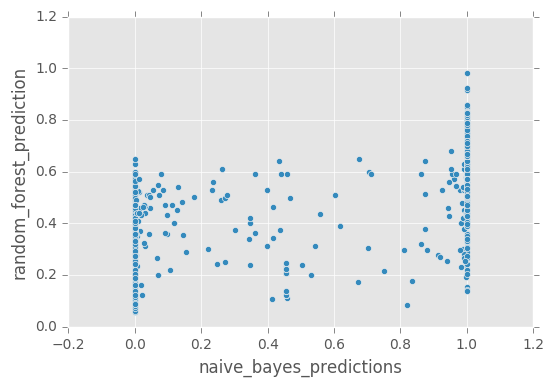

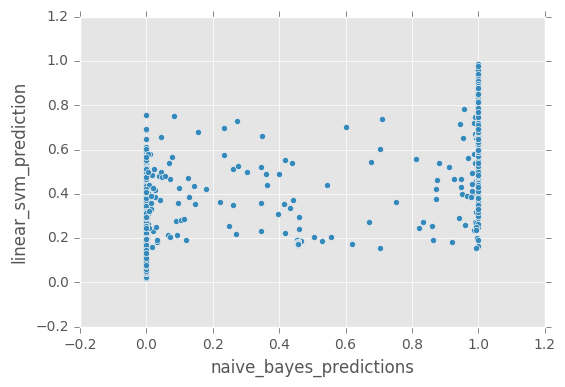

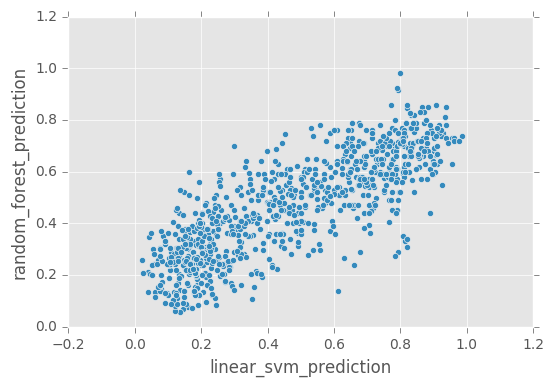

In [75]:
df.plot.scatter(x='naive_bayes_predictions',y='random_forest_prediction')
df.plot.scatter(x='naive_bayes_predictions',y='linear_svm_prediction')
df.plot.scatter(x='linear_svm_prediction',y='random_forest_prediction')
plt.show()

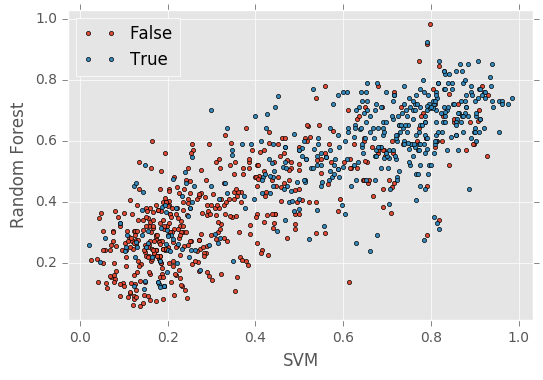

In [78]:
groups = df.groupby('saas_subscription')
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.linear_svm_prediction, group.random_forest_prediction, marker='o', linestyle='', ms=3, label=name,
           )
ax.legend(loc='upper left')
ax.set_xlabel("SVM")
ax.set_ylabel("Random Forest")
plt.show()

In [294]:
#stacking using logistic regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(df[['naive_bayes_predictions','random_forest_prediction','linear_svm_prediction']],df['saas_subscription'])
print 'traing predictions'
print classification_report(df['saas_subscription'],
                clf.predict(df[['naive_bayes_predictions','random_forest_prediction','linear_svm_prediction']]))
print 'cross-validation predictions'
print classification_report(df['saas_subscription'],cross_val_predict(clf,
        df[['naive_bayes_predictions','random_forest_prediction','linear_svm_prediction']],df['saas_subscription'],cv=10))

traing predictions
             precision    recall  f1-score   support

      False       0.77      0.76      0.77       482
       True       0.72      0.73      0.72       403

avg / total       0.75      0.75      0.75       885

cross-validation predictions
             precision    recall  f1-score   support

      False       0.77      0.76      0.76       482
       True       0.71      0.73      0.72       403

avg / total       0.74      0.74      0.74       885



In [295]:
#stacking using random forest
clf = RandomForestClassifier(n_estimators=200)
clf.fit(df[['naive_bayes_predictions','random_forest_prediction','linear_svm_prediction']],df['saas_subscription'])
print 'traing predictions'
print classification_report(df['saas_subscription'],
                clf.predict(df[['naive_bayes_predictions','random_forest_prediction','linear_svm_prediction']]))
print 'cross-validation predictions'
print classification_report(df['saas_subscription'],cross_val_predict(clf,
        df[['naive_bayes_predictions','random_forest_prediction','linear_svm_prediction']],df['saas_subscription'],cv=10))

traing predictions
             precision    recall  f1-score   support

      False       0.98      0.99      0.99       482
       True       0.99      0.98      0.98       403

avg / total       0.98      0.98      0.98       885

cross-validation predictions
             precision    recall  f1-score   support

      False       0.74      0.73      0.74       482
       True       0.68      0.68      0.68       403

avg / total       0.71      0.71      0.71       885



In [296]:
#stacking using svm
C=0.01
clf = SVC(C=C,kernel='linear')
clf.fit(df[['naive_bayes_predictions','random_forest_prediction','linear_svm_prediction']],df['saas_subscription'])
print 'traing predictions'
print classification_report(df['saas_subscription'],
                clf.predict(df[['naive_bayes_predictions','random_forest_prediction','linear_svm_prediction']]))
print 'cross-validation predictions'
print classification_report(df['saas_subscription'],cross_val_predict(clf,
        df[['naive_bayes_predictions','random_forest_prediction','linear_svm_prediction']],df['saas_subscription'],cv=10))

traing predictions
             precision    recall  f1-score   support

      False       0.78      0.72      0.75       482
       True       0.69      0.76      0.72       403

avg / total       0.74      0.74      0.74       885

cross-validation predictions
             precision    recall  f1-score   support

      False       0.78      0.72      0.75       482
       True       0.69      0.76      0.72       403

avg / total       0.74      0.74      0.74       885



In [259]:
#majority voting
def get_majority_pred(pred1,pred2,pred3):
    pred1_class,pred2_class,pred3_class = pred1>0.5,pred2>0.5,pred3>0.5
    if (pred1_class and pred2_class) or (pred1_class and pred3_class) or (pred2_class and pred3_class):
        return True
    else:
        return False
# df.apply(lambda row: 
#          get_majority_pred(row['naive_bayes_predictions'],row['random_forest_prediction'],row['linear_svm_prediction']))

In [306]:
# majority voting
print classification_report(df['saas_subscription'],
                            ((df['naive_bayes_predictions']>0.5) & (df['random_forest_prediction']>0.5))|\
                            ((df['linear_svm_prediction']>0.5) & (df['random_forest_prediction']>0.5))|\
                            ((df['naive_bayes_predictions']>0.5) & (df['linear_svm_prediction']>0.5)))

             precision    recall  f1-score   support

      False       0.77      0.77      0.77       482
       True       0.73      0.73      0.73       403

avg / total       0.75      0.75      0.75       885



In [307]:
# any true voting
print classification_report(df['saas_subscription'],
       (df['naive_bayes_predictions']>0.5) | (df['random_forest_prediction']>0.5)|(df['linear_svm_prediction']>0.5))

             precision    recall  f1-score   support

      False       0.83      0.64      0.72       482
       True       0.66      0.85      0.74       403

avg / total       0.75      0.73      0.73       885



In [325]:
print 'True,nb pred<0.1: {}'.format(df[(df['saas_subscription']==True) &(df['naive_bayes_predictions']<0.1)].shape)
print 'True,nb pred<0.2: {}'.format(df[(df['saas_subscription']==True) &(df['naive_bayes_predictions']<0.2)].shape)
print 'True,nb pred<0.4: {}'.format(df[(df['saas_subscription']==True) &(df['naive_bayes_predictions']<0.4)].shape)
print 'False,nb pred>0.9: {}'.format(df[(df['saas_subscription']==False) &(df['naive_bayes_predictions']>0.9)].shape)
print 'False,nb pred>0.8: {}'.format(df[(df['saas_subscription']==False) &(df['naive_bayes_predictions']>0.8)].shape)
print 'False,nb pred>0.6: {}'.format(df[(df['saas_subscription']==False) &(df['naive_bayes_predictions']>0.6)].shape)
print 'False,nb pred<0.2: {}'.format(df[(df['saas_subscription']==False) &(df['naive_bayes_predictions']<0.1)].shape)
print 'True,nb pred>0.8: {}'.format(df[(df['saas_subscription']==True) &(df['naive_bayes_predictions']>0.8)].shape)

True,nb pred<0.1: (76, 11)
True,nb pred<0.2: (79, 11)
True,nb pred<0.4: (86, 11)
False,nb pred>0.9: (128, 11)
False,nb pred>0.8: (133, 11)
False,nb pred>0.6: (137, 11)
False,nb pred<0.2: (297, 11)
True,nb pred>0.8: (302, 11)


In [326]:
print 'True,svm pred<0.1: {}'.format(df[(df['saas_subscription']==True) &(df['linear_svm_prediction']<0.1)].shape)
print 'True,svm pred<0.2: {}'.format(df[(df['saas_subscription']==True) &(df['linear_svm_prediction']<0.2)].shape)
print 'True,svm pred<0.4: {}'.format(df[(df['saas_subscription']==True) &(df['linear_svm_prediction']<0.4)].shape)
print 'False,svm pred>0.9: {}'.format(df[(df['saas_subscription']==False) &(df['linear_svm_prediction']>0.9)].shape)
print 'False,svm pred>0.8: {}'.format(df[(df['saas_subscription']==False) &(df['linear_svm_prediction']>0.8)].shape)
print 'False,svm pred>0.6: {}'.format(df[(df['saas_subscription']==False) &(df['linear_svm_prediction']>0.6)].shape)
print 'False,svm pred<0.2: {}'.format(df[(df['saas_subscription']==False) &(df['linear_svm_prediction']<0.2)].shape)
print 'True,svm pred>0.8: {}'.format(df[(df['saas_subscription']==True) &(df['linear_svm_prediction']>0.8)].shape)

True,svm pred<0.1: (5, 11)
True,svm pred<0.2: (38, 11)
True,svm pred<0.4: (79, 11)
False,svm pred>0.9: (8, 11)
False,svm pred>0.8: (29, 11)
False,svm pred>0.6: (80, 11)
False,svm pred<0.2: (176, 11)
True,svm pred>0.8: (106, 11)


In [16]:
def ks_statistic(score,dv):
    ''' assumes 1 as good and 0 as bad'''
    data = pd.DataFrame({'score':score,'dv':dv})
    data['good'] = data['dv']
    data['bad'] = 1-data['good']
    # data['bucket'] = pd.qcut(data.score, 10) #causing error
    bins = pd.core.algorithms.quantile(np.unique(data['score']), np.linspace(0, 1, 11))
    data['bucket'] = pd.tools.tile._bins_to_cuts(data['score'], bins, include_lowest=True)
    grouped = data.groupby('bucket', as_index = False)
    agg1 = pd.DataFrame({'min_scr':grouped.min().score})
    agg1['max_scr'] = grouped.max().score
    agg1['goods'] = grouped.sum().good
    agg1['bads'] = grouped.sum().bad
    agg1['total'] = agg1.bads + agg1.goods
    agg2 = (agg1.sort_index(by = 'min_scr')).reset_index(drop = True)
    agg2['odds'] = (agg2.goods / agg2.bads).apply('{0:.2f}'.format)
    agg2['bad_rate'] = (agg2.bads / agg2.total).apply('{0:.2%}'.format)
    agg2['ks'] = np.round(((agg2.bads / data.bad.sum()).cumsum() - (agg2.goods / data.good.sum()).cumsum()), 4) * 100
    flag = lambda x: '<----' if x == agg2.ks.max() else ''
    agg2['max_ks'] = agg2.ks.apply(flag)
    return agg2

In [346]:
ks_statistic(df['naive_bayes_predictions'],df['saas_subscription'])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


,min_scr,max_scr,goods,bads,total,odds,bad_rate,ks,max_ks
0,1.143976e-43,8.846557e-18,12.0,54,66.0,0.22,81.82%,8.23,
1,1.067158e-17,3.182243e-13,10.0,56,66.0,0.18,84.85%,17.36,
2,3.438283e-13,4.611275e-10,7.0,59,66.0,0.12,89.39%,27.87,
3,4.776421e-10,1.282843e-06,17.0,52,69.0,0.33,75.36%,34.44,
4,1.531423e-06,1.931688e-03,18.0,48,66.0,0.38,72.73%,39.93,
5,2.605968e-03,3.621328e-01,22.0,43,65.0,0.51,66.15%,43.39,
6,3.970038e-01,9.940223e-01,35.0,60,95.0,0.58,63.16%,47.15,<----
7,9.963162e-01,9.999984e-01,39.0,27,66.0,1.44,40.91%,43.08,
8,9.999986e-01,1.000000e+00,39.0,28,67.0,1.39,41.79%,39.21,
9,1.000000e+00,1.000000e+00,204.0,55,259.0,3.71,21.24%,0.00,


In [20]:
ks_statistic(df['linear_svm_prediction'],df['saas_subscription'])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


,min_scr,max_scr,goods,bads,total,odds,bad_rate,ks,max_ks
0,0.021285,0.134246,13.0,72,85.0,0.18,84.71%,11.71,
1,0.135640,0.189011,17.0,85,102.0,0.20,83.33%,25.13,
2,0.189617,0.245498,22.0,69,91.0,0.32,75.82%,33.98,
3,0.245562,0.339939,19.0,66,85.0,0.29,77.65%,42.96,
4,0.341498,0.446306,25.0,60,85.0,0.42,70.59%,49.21,<----
5,0.448330,0.570784,48.0,46,94.0,1.04,48.94%,46.84,
6,0.573070,0.678260,60.0,26,86.0,2.31,30.23%,37.35,
7,0.679574,0.766390,67.0,19,86.0,3.53,22.09%,24.66,
8,0.766872,0.831766,64.0,22,86.0,2.91,25.58%,13.35,
9,0.832168,0.984072,68.0,17,85.0,4.00,20.00%,0.00,


In [21]:
#going with svm
#tfidf_vectorizer
C = 0.001
svm_model = make_pipeline(StandardScaler(with_mean=False),SVC(C=C,kernel='linear',probability=True)) 
svm_model.fit(tfidf_n_vars,df['saas_subscription'])

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=False, with_std=True)), ('svc', SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [ ]:
ks_dets = ks_statistic(df['linear_svm_prediction'],df['saas_subscription'])

In [35]:
bin_boundaries = [0]+list(ks_dets['max_scr'])[:-1]+[1]
bin_labels = range(10)
pd.cut(df['linear_svm_prediction'], bin_boundaries,labels=bin_labels).head()

0    1
1    2
2    1
3    0
4    4
Name: linear_svm_prediction, dtype: category
Categories (10, int64): [0 < 1 < 2 < 3 ... 6 < 7 < 8 < 9]

In [36]:
pd.cut(df['linear_svm_prediction'], bin_boundaries,labels=bin_labels).value_counts()

1    102
5     94
2     91
8     86
7     86
6     86
9     85
4     85
3     85
0     85
Name: linear_svm_prediction, dtype: int64

In [68]:
df[df['website'].str.contains('triumphcoffeelab.com')]

,website,demo_present,login_present,pricing_present,score,website_text,saas_subscription,website_text_phrases,naive_bayes_predictions,random_forest_prediction,linear_svm_prediction,per_month_present
293,http://www.triumphcoffeelab.com,False,False,False,0.9,Triumph Coffee Lab Triumph Coffee Lab Our Stor...,False,Triumph Coffee Lab Triumph Coffee Lab Story Wh...,5.010761e-26,0.263478,0.123807,False


In [38]:
import pickle
with open('chargebee_model_objects.pkl','w') as f:
    pickle.dump({'vectorizer':tfidf_vectorizer,'model':svm_model,'bin_boundaries':bin_boundaries,
                'bin_labels':bin_labels},f)